# Predictions of survival pattern using Titanic Dataset

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

Let's build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [324]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Impoerting the Libraries

In [325]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

## Reading the data in

In [326]:
traindf=pd.read_csv('/kaggle/input/titanic/train.csv')
testdf=pd.read_csv('/kaggle/input/titanic/test.csv')

# Data Analysis and Vizualisation

In [327]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### The training dataset has null and missing values in Cabin, Age and Embarked. The Cabin row has the most missing datas. I might drop this row as it's missing more than 70% of the data.

In [328]:
traindf.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [329]:
traindf.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Age Vs Sex

Text(0.5, 1.0, 'Male')

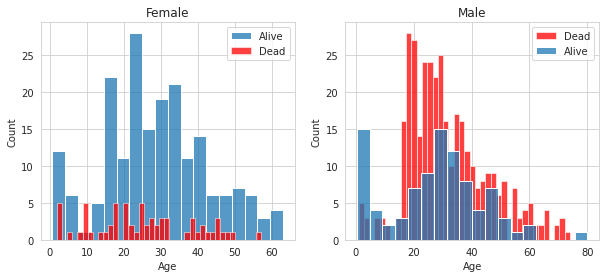

In [330]:
survive = 'Alive'
notsurvive = 'Dead'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = traindf[traindf['Sex']=='female']
men = traindf[traindf['Sex']=='male']
ax = sns.histplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survive, ax = axes[0], kde =False)
ax = sns.histplot(women[women['Survived']==0].Age.dropna(),color="red", bins=40, label = notsurvive, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')

ax = sns.histplot(men[men['Survived']==0].Age.dropna(),color="red", bins=40, label = notsurvive, ax = axes[1], kde = False)
ax = sns.histplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survive, ax = axes[1], kde = False)
ax.legend()
ax.set_title('Male')

#### These graph shows that there is a high probability for women to survive the sinking than men. For women, the highest percent of women who might be saved were around 15 to 42 years old.

#### For men, it's relatively low whereas the infants might stand a chance for survival.

# Embarked Vs Pclass

The people survived Pclass 1 =  136  out of  216
The people survived Pclass 2 =  87  out of  184
The people survived Pclass 3 =  119  out of  491


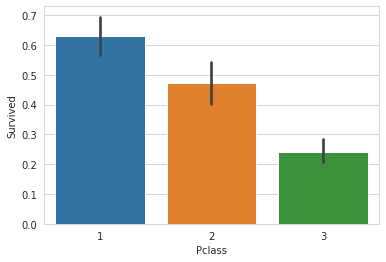

In [331]:
sns.barplot(x='Pclass', y='Survived', data=traindf)

survived = traindf.loc[traindf.Pclass == 1]["Survived"]
print("The people survived Pclass 1 = ",sum(survived)," out of ",len(survived))

survived = traindf.loc[traindf.Pclass == 2]["Survived"]
print("The people survived Pclass 2 = ",sum(survived)," out of ",len(survived))

survived = traindf.loc[traindf.Pclass == 3]["Survived"]
print("The people survived Pclass 3 = ",sum(survived)," out of ",len(survived))

#### The higher Pclass has the best survival rate than other Pclasses. Whereas Pclass 3 has a low probability of survival.

In [332]:
traindf['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

# Embarked Vs Sex Vs Pclass

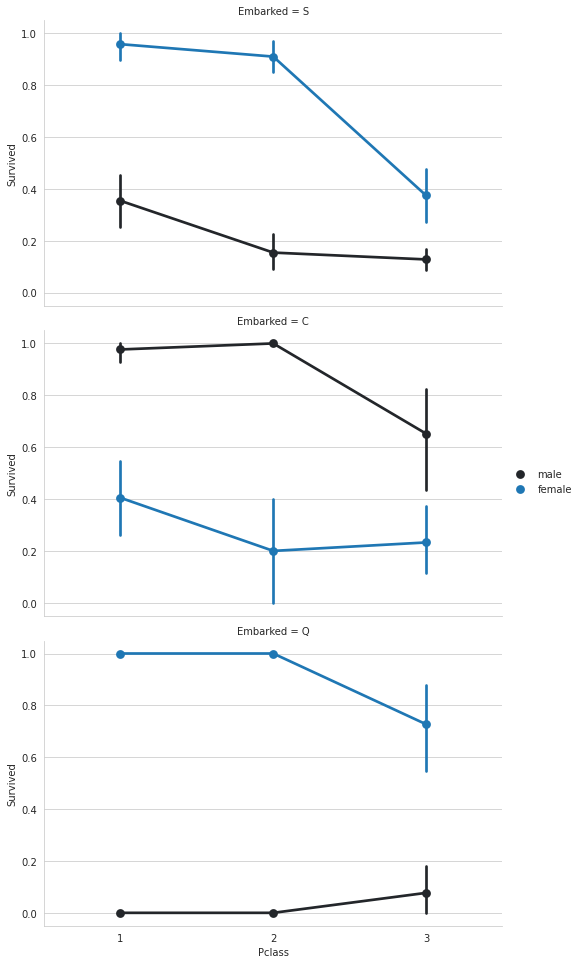

In [333]:
FacetGrid = sns.FacetGrid(traindf, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

#### The survival rate highly depends on the gender of the passenger. In these graphs, it shows that on port Q and S, there is a higher probabailty of survival for women. Whereas, at port C, men has higher survival rate.

#### Let us see how many survived or not at each embarked to see things more clearer.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

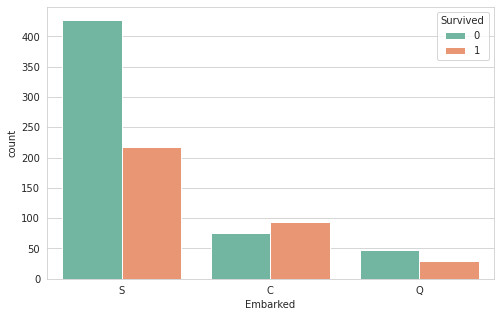

In [334]:
plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')
sns.countplot(x = 'Embarked',hue='Survived',data=traindf, palette = "Set2" )

#### We can use SibSp and Parch to see whether the survival rate increases or decreases if relatives or family is present on the ship. We will make a new feature to determine whether a passenger is alone or not.

#### I still don't know we will need it or not but we have follow all the leads

In [335]:
d = [traindf, testdf]
for data in d:
    data['related'] = data['SibSp'] + data['Parch'] 
    data.loc[data['related'] > 0, 'alone'] = 1
    data.loc[data['related'] == 0, 'alone'] = 0
    data['alone'] = data['alone'].astype(int)
traindf['alone'].value_counts()

0    537
1    354
Name: alone, dtype: int64

# Relative Vs Survived

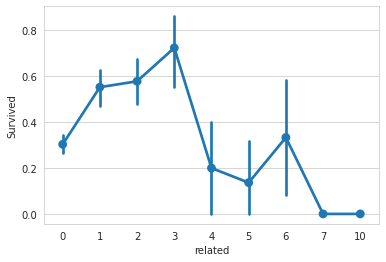

In [336]:
axes = sns.pointplot(x='related',y='Survived', data=traindf)

#### If a passenger have more than 1 and less than 3, they have increasing chance of survival. With three relatives, you have the best survival rate. Whereas after three, a passenger have a pretty low survival rate.

# Cabin

#### Earlier I thought i moght drop this row but there is a great way to make this a feature useful. As the starting of eac Cabin has a alphabet. This alphabet represent the deck where the passenger is staying. It might prove a second-best lead till now. Let X be the missing values.

In [337]:
traindf['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in traindf['Cabin'] ])
testdf['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in testdf['Cabin'] ])

## Cabin Vs Survived

<Figure size 576x360 with 0 Axes>

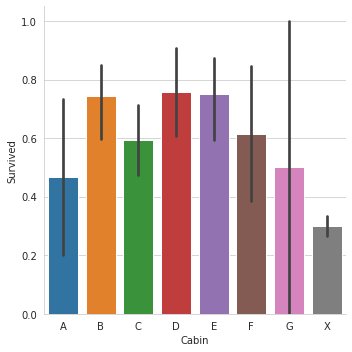

In [338]:
plt.figure(figsize=(8, 5))
g = sns.catplot(y="Survived",x="Cabin",data=traindf,kind="bar",order=['A','B','C','D','E','F','G','X'])

# Data Pre-processing 

### Change Cabin alphabet into integers for building model

In [339]:
traindf["Cabin"] = traindf["Cabin"].map({"X":0, "A":1, "B" : 2 , "C":3, "D":4, "E":5, "F":6, "G":7,"T":0})
traindf["Cabin"] = traindf["Cabin"].astype(int)
testdf["Cabin"] = testdf["Cabin"].map({"X":0, "A":1, "B" : 2 , "C":3, "D":4, "E":5, "F":6, "G":7,"T":0})
testdf["Cabin"] = testdf["Cabin"].astype(int)

### Filling up the missing values of Age feature using random values which is based on mean and std value.

In [340]:
data = [traindf, testdf]
for dataset in data:
    mean = traindf["Age"].mean()
    std = testdf["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = traindf["Age"].astype(int)
    

### Filling up the missing values of Embarked with the common value and for Fare, i am just putting zero

In [341]:
val = 'S'
d = [traindf, testdf]
for dataset in d:
    dataset['Embarked'] = dataset['Embarked'].fillna(val)
    
for dataset in d:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

### Making all the other features to integer for using in making models

In [342]:
genders = {"male": 0, "female": 1}
ports = {"S": 1, "C": 2, "Q": 3}
d = [traindf, testdf]

for dataset in d:
    dataset['Sex'] = dataset['Sex'].map(genders)
    
for dataset in d:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

## Let's turn Age and Fare feature into groups which will helps later on. Just be careful wih dividing the groups, make it equal.

In [343]:
d = [traindf, testdf]
for dataset in d:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6


### For Fare feature, we can't just divide it in the usual way. If we did, more tah 80% of values will fall under in the first group. Thus, we will use qcut() because qcut tries to divide up the underlying data into equal sized bins. This is based on percentile on distribution of data and not the number of bins.

> #### d = [traindf, testdf]
> for dataset in d:
> > fare = pd.qcut(dataset['Fare'], q=' ',duplicates='drop')        
> #### fare

#### I didn't put this code in this notebook.

In [344]:
d = [traindf, testdf] 
for dataset in d: 
    dataset.loc[ dataset['Fare'] <= 7.00, 'Fare'] = 0 
    dataset.loc[(dataset['Fare'] > 7.00) & (dataset['Fare'] <= 8.00), 'Fare'] = 1 
    dataset.loc[(dataset['Fare'] > 8.00) & (dataset['Fare'] <= 14.0), 'Fare']   = 2 
    dataset.loc[(dataset['Fare'] > 14) & (dataset['Fare'] <= 26), 'Fare']   = 3 
    dataset.loc[(dataset['Fare'] > 26) & (dataset['Fare'] <= 55.5), 'Fare']   = 4 
    dataset.loc[ dataset['Fare'] > 55.5, 'Fare'] = 5 
    dataset['Fare'] = dataset['Fare'].astype(int)

## Creating new features after see the data and how they are co-related tp each other


### Fare Per Person

In [345]:
d = [traindf, testdf]

for dataset in d:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['related']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

### Pclass times Embarked

In [346]:
for dataset in d:
    dataset['Pclass_Embarked'] = dataset['Embarked']*(dataset['Pclass'])

### Age times Pclass

In [347]:
for dataset in d:
    dataset['Age_Pclass'] = dataset['Age']*(dataset['Pclass'])

#### Let's drop the features we don't need in training and testing dataframes. I also noticed that Alone feature is not that important. So, i also dropped it. 

In [348]:
traindf=traindf.drop(['PassengerId','Name','Ticket','alone'],axis=1)
testdf=testdf.drop(['Name','Ticket','alone'],axis=1)
traindf.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,related,Fare_Per_Person,Pclass_Embarked,Age_Pclass
0,0,3,0,2,1,0,0,0,1,1,0,3,6
1,1,1,1,5,1,0,5,3,2,1,2,2,5
2,1,3,1,3,0,0,0,0,1,0,0,3,9
3,1,1,1,5,1,0,4,3,1,1,2,1,5
4,0,3,0,5,0,0,1,0,1,0,1,3,15


In [349]:
testdf.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,related,Fare_Per_Person,Pclass_Embarked,Age_Pclass
0,892,3,0,2,0,0,0,0,3,0,0,9,6
1,893,3,1,5,1,0,0,0,1,1,0,3,15
2,894,2,0,3,0,0,2,0,3,0,2,6,6
3,895,3,0,5,0,0,1,0,1,0,1,3,15
4,896,3,1,5,1,1,2,0,1,2,0,3,15


# Let's build the model

### I am used different models and Random Forest Classifier is the best suited for now.

#### Let's separate the train and test sets

In [350]:
X_train = traindf.drop("Survived", axis=1)
Y_train = traindf["Survived"]
X_test  = testdf.drop("PassengerId", axis=1).copy()

#### Building the model 

In [351]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, Y_train)

Ypred =rf.predict(X_test)

rf.score(X_train, Y_train)
score  = round(rf.score(X_train, Y_train) * 100, 2)
score

93.04

#### Let's see how many we did predict right

In [352]:
from sklearn.metrics import confusion_matrix
sub=pd.read_csv('../input/titanic/gender_submission.csv')
confusion_matrix(sub["Survived"], Ypred)


array([[213,  53],
       [ 45, 107]])

#### 220 predictions are true positves and 112 are true negatives. Around 82% accuracy can be found using these features and this model.

## Let's use K-Fold Cross Validation

In [353]:
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.77777778 0.80898876 0.76404494 0.85393258 0.87640449 0.83146067
 0.84269663 0.80898876 0.84269663 0.84269663]
Mean: 0.8249687890137329
Standard Deviation: 0.03304381273425135


#### Our model has a acuuracy of 82% with standard deviation of 3% which means that the acuuracy of this model can differ +-4%.

### Saving the predicted file

In [354]:
submission = pd.DataFrame({'PassengerId':testdf['PassengerId'],'Survived':Ypred})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [355]:
submission.to_csv('Titanic_Predictions.csv',index=False)
print('File Saved.')

File Saved.


# Conclusion 

### It's a great dataset to start Machine Learning journey. The features can be made more accurate. I dropped the Ticket and Name feature, but further analysis can prove that those features are more important. The model can be improved a lot. Feel free to explore on you own. During data pre-processing session, the missing values can be handled more efficiently and accurately and new features can be created to better performance of the model.

### More extensive research and comparing and plotting feature against others and remove the other unnecessary features will make improvement. I didn't use hyperparameter  for Random Forest Classifier as i am still learning about it. Extensive use of hyperparameter tuning on the model can improve the overall performance.